In [14]:
import numpy as np
import random as rnd
import networkx as nx
import csv
import matplotlib.pyplot as plt


N = 1000            # Agent number
kappa = 0.1            # Thermal coefficient for Pairwise Fermi update
C = 1                  # C: Cooperation
D = 0                  # D: Defection

num_play = 1000        # Number of total timestep in a single episode
num_ens = 1            # Number of total episode in a single simulation for taking ensemble average

In [15]:
class Agent:
    def __init__(self, id):
        self.id = id
        self.point = 0.0
        self.strategy = D
        self.next_strategy = None 
        self.neighbors = []

In [16]:
# Generate network and set neighbors
def network(agent_list):  # "agent_list " is the list of agent object
    G = nx.barabasi_albert_graph(N,8)      # barabasi_albert_graph(n,m) n:node number, m: number of edges to rearange

    # Set neighbors to all agents
    for focal in agent_list: 
        neighbors_id = list(G[focal.id]) # G[] is dictionary. list(G[]) is the list of node focal.id connects.

        for neighbor in agent_list:
            if neighbor.id in neighbors_id: 
                focal.neighbors.append(neighbor)

In [17]:
def initialize(agent_list, init_C):
    for focal in agent_list:
        if focal.id in init_C:
            focal.strategy = C
        else:
            focal.strategy = D

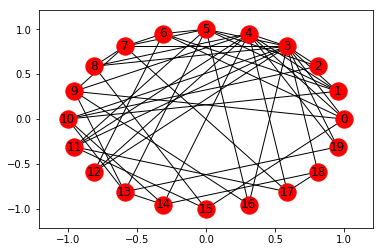

In [18]:
G1 = nx.barabasi_albert_graph(20,3)
pos  = nx.circular_layout(G1)
nx.draw_networkx(G1,pos)
plt.show()

In [19]:
nx.average_shortest_path_length(G)

NameError: name 'G' is not defined

In [ ]:
agent_list = [Agent(id) for id in range(20)]

G = nx.barabasi_albert_graph(20,2)      
for focal in agent_list: 
    neighbors_id = list(G[focal.id])
G[2] # display node num that node 2 connect. Type is dictionary

In [ ]:
def initialize(agent_list, init_C):
    for focal in agent_list:
        if focal.id in init_C:
            focal.strategy = C
        else:
            focal.strategy = D

In [ ]:
def payoff(Dg, Dr, agent_list): 
    R = 1       # Reward
    S = -Dr     # Sucker
    T = 1+Dg    # Temptation
    P = 0       # Punishment

    for focal in agent_list:
        focal.point = 0.0

        for neighbor in focal.neighbors:
            if focal.strategy == C and neighbor.strategy == C:    
                focal.point += R 
            if focal.strategy == C and neighbor.strategy == D:   
                focal.point += S
            if focal.strategy == D and neighbor.strategy == C:   
                focal.point += T
            if focal.strategy == D and neighbor.strategy == D:  
                focal.point += P

In [ ]:
# Decide next strategy by Pairwise-Fermi rule      
def PF_update(agent_list): 
    for focal in agent_list:
        opp = rnd.choice(focal.neighbors)     # Decide opponent
        if opp.strategy != focal.strategy and rnd.random() <= 1/(1+np.exp((focal.point - opp.point)/kappa)):
            focal.next_strategy = opp.strategy
        else:
            focal.next_strategy = focal.strategy

def update_strategy(agent_list):
    for focal in agent_list:
        focal.strategy = focal.next_strategy



In [ ]:
# Count the number of cooperators and get the fraction of cooperation(=Fc)
def count(agent_list):
    Fc = len(list(filter(lambda agent: agent.strategy == C, agent_list)))/N
    return Fc

In [ ]:
prices = [3000,2000,1000,500]
paymentList = list()
for price in prices:
    paymentList.append(price*1.08)
    
print (paymentList)

In [ ]:
paymentList = list(map(lambda price: price*1.08,prices))
paymentList

In [ ]:
priceList = list(filter(lambda price:price>3000,prices))
priceList.sort()

print (priceList)


In [20]:
def main():

    agent_list = [Agent(id) for id in range(N)]
    network(agent_list)

    # Ensemble loop
    for ens in range(1, num_ens+1):

        # Reset the seed of random number                                   
        rnd.seed()

        # Determine initial C agent over one episode
        init_C = [id for id in rnd.sample(range(N), k= int(N/2))]

        # Setting for output file
        filename = 'output{}.csv'.format(ens)
        f = open(filename, 'w')        
        header = ['Dg', 'Dr', 'Fraction of Cooperation']
        writer = csv.writer(f)
        writer.writerow(header)

        # Dilemma strength loop
        for Dr in np.arange(0, 1.1, 0.1):          # Stag-Hunt type dilemma              
            for Dg in np.arange(0, 1.1, 0.1):      # Chicken type dilemma

                # Initialization
                initialize(agent_list, init_C)
                initFc = count(agent_list)
                Fc = [initFc]
                print('Dg:{Dg:.1f}, Dr:{Dr:.1f}, Time:{0}, Fc:{Fc[0]:.3f}')

                # Time evolution loop
                for t in range(1, num_play+1):
                    payoff(Dg, Dr, agent_list)
                    PF_update(agent_list)
                    update_strategy(agent_list)
                    Fc.append(count(agent_list))
                    print(f'Dg:{Dg:.1f}, Dr:{Dr:.1f}, Time:{t}, Fc:{Fc[t]:.3f}')

                    # Following if statements are the condition for finishing calculation
                    if Fc[t] == 0 or Fc[t] == 1:
                        print(f'Dg:{Dg:.1f}, Dr:{Dr:.1f}, Time:{t}, Fc(0 or 1):{Fc[t]: .3f}')
                        writer.writerow([f'{Dg:.1f}', f'{Dr:.1f}', f'{Fc[t-1]:.3f}'])
                        break

                    if t >= 100:
                        if np.absolute(np.mean(Fc[t-100:t-1]) - Fc[t])/Fc[t] < 0.001:
                            print(f'Dg:{Dg:.1f}, Dr:{Dr:.1f}, Time:{t}, Fc(Converged):{Fc[t]: .3f}')
                            writer.writerow([f'{Dg:.1f}', f'{Dr:.1f}', f'{Fc[t-1]:.3f}'])
                            break

                    if t == num_play:
                        FcFin = np.mean(Fc[t-99:t])
                        print(f'Dg:{Dg:.1f}, Dr:{Dr:.1f}, Time:{t}, Fc(Final timestep):{FcFin:.3f}')
                        writer.writerow([f'{Dg:.1f}', f'{Dr:.1f}', f'{FcFin:.3f}'])
                        break

        f.close()

if __name__ == '__main__':
    main()

Dg:0.0, Dr:0.0, Time:0, Fc:0.500
Dg:0.0, Dr:0.0, Time:1, Fc:0.480
Dg:0.0, Dr:0.0, Time:2, Fc:0.486
Dg:0.0, Dr:0.0, Time:3, Fc:0.488
Dg:0.0, Dr:0.0, Time:4, Fc:0.507
Dg:0.0, Dr:0.0, Time:5, Fc:0.498
Dg:0.0, Dr:0.0, Time:6, Fc:0.484
Dg:0.0, Dr:0.0, Time:7, Fc:0.510
Dg:0.0, Dr:0.0, Time:8, Fc:0.493
Dg:0.0, Dr:0.0, Time:9, Fc:0.469

/Users/puca/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in exp



Dg:0.0, Dr:0.0, Time:10, Fc:0.464
Dg:0.0, Dr:0.0, Time:11, Fc:0.448
Dg:0.0, Dr:0.0, Time:12, Fc:0.447
Dg:0.0, Dr:0.0, Time:13, Fc:0.459
Dg:0.0, Dr:0.0, Time:14, Fc:0.496
Dg:0.0, Dr:0.0, Time:15, Fc:0.487
Dg:0.0, Dr:0.0, Time:16, Fc:0.520
Dg:0.0, Dr:0.0, Time:17, Fc:0.492
Dg:0.0, Dr:0.0, Time:18, Fc:0.527
Dg:0.0, Dr:0.0, Time:19, Fc:0.503
Dg:0.0, Dr:0.0, Time:20, Fc:0.472
Dg:0.0, Dr:0.0, Time:21, Fc:0.450
Dg:0.0, Dr:0.0, Time:22, Fc:0.433
Dg:0.0, Dr:0.0, Time:23, Fc:0.442
Dg:0.0, Dr:0.0, Time:24, Fc:0.443
Dg:0.0, Dr:0.0, Time:25, Fc:0.485
Dg:0.0, Dr:0.0, Time:26, Fc:0.482
Dg:0.0, Dr:0.0, Time:27, Fc:0.516
Dg:0.0, Dr:0.0, Time:28, Fc:0.505
Dg:0.0, Dr:0.0, Time:29, Fc:0.514
Dg:0.0, Dr:0.0, Time:30, Fc:0.522
Dg:0.0, Dr:0.0, Time:31, Fc:0.533
Dg:0.0, Dr:0.0, Time:32, Fc:0.552
Dg:0.0, Dr:0.0, Time:33, Fc:0.539
Dg:0.0, Dr:0.0, Time:34, Fc:0.575
Dg:0.0, Dr:0.0, Time:35, Fc:0.604
Dg:0.0, Dr:0.0, Time:36, Fc:0.640
Dg:0.0, Dr:0.0, Time:37, Fc:0.621
Dg:0.0, Dr:0.0, Time:38, Fc:0.667
Dg:0.0, Dr:0.

KeyboardInterrupt: 

TypeError: randint() missing 2 required positional arguments: 'a' and 'b'

In [39]:
rnd.sample(range(2),k = 1)

[1]

In [41]:
a = 1
print (f"bbb{a}")

bbb1


In [47]:
path_w = '/Users/puca/python/test/test_w.txt'

s = 'New file'

with open(path_w, mode='w') as f:
    f.write(s)

with open(path_w) as f:
    print(f.read())


New file


In [ ]:
with open('some.csv','w') as f: 
    writer  = csv.writer(f,lineterminatoe = "/n")

In [49]:
import matplotlib.animation as animation

fig = plt.figure()
type(fig)

matplotlib.figure.Figure

In [56]:
ims= []

In [58]:
    rand = np.random.randn(100)
    im = plt.plot(rand)
    ims.append(im)
    ims
    

[[<matplotlib.lines.Line2D at 0x1119eb438>],

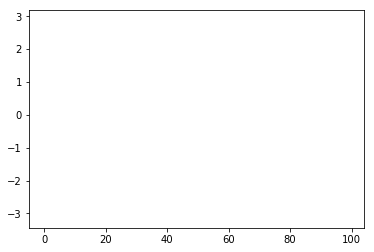

In [63]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()

ims = []

for i in range(10):
        rand = np.random.randn(100)     # 100個の乱数を生成
        im = plt.plot(rand)             # 乱数をグラフにする
        ims.append(im)                  # グラフを配列 ims に追加

# 10枚のプロットを 100ms ごとに表示
ani = animation.ArtistAnimation(fig, ims, interval=100)
plt.show()


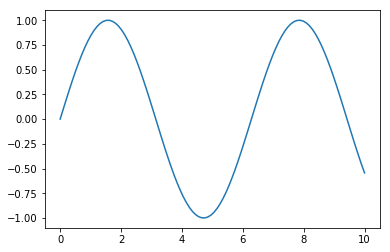

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(0, 10, 100)
y  = np.sin(x)
plt.plot(x, y)

In [66]:
a = [i for i in range(100)]
mean =  np.mean(a)
mean

49.5

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt